In [128]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd

In [129]:
def get_inlier_limits(series_of_observations):
    """
    computes the bounds of outlier obervations using tukey's method,
    i.e. 1.5 x iqr below q1 or above q3
    """
    series_of_observations = sorted(series_of_observations)
    Q1,Q3 = np.percentile(series_of_observations, [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

def check_whether_inlier(value, lower, upper):
    """checks whether input value is within bounds """
    return (value>=lower) & (value<=upper)

def sample_with_replacement(a_series, num_samples):
    return None

def drop_nulls(a_series):
    """returns the input series with all the null rows dropped"""
    return a_series[~ a_series.isna()]

def case_histogram(times, casename, idstr):
    """given a series of timing observations, plots their histogram and saves to disk"""
    median = np.median(times)
    plt.figure(figsize=(13,9))
    n, bins, patches = plt.hist(x=times, bins='auto', color='blue',
                                alpha=0.7, rwidth=0.85);
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('time [ms]')
    plt.ylabel('frequency')
    plt.title(casename+' '+idstr)
    # plt.text(23, 45, r'$\mu=, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.savefig(os.path.join(graph_folder,casename+'_'+idstr+'.png'))
#     plt.show()
    
def histogram_of_means(means, casename):
    """given a series of timing sample means, plots their histogram and saves to disk"""
    median = np.median(means)
    std    = np.std(means)

    verticals = [
        median - std,
        median,
        median + std
    ]

    title = casename\
        + ' means of samples.'\
        +' median: '+ str(round(median,0))\
        +' std:'+str(round(std,0))

    plt.figure(figsize=(15,9))
    
    n, bins, patches = plt.hist(x=means, bins='auto', color='red',
                                alpha=0.7, rwidth=0.85)
    
    plt.grid(axis='y', alpha=0.7)
    plt.xlabel('time [ms]')
    plt.ylabel('frequency')
    plt.title(title)

    for x_position in verticals:
        plt.axvline(x=x_position, color='gray', linestyle='--')

    plt.axvline(x=median, color='k', linestyle='-', lw=3)
    
#     plt.text(23, 45, r'$\mu=, b=3$')
    # Set a clean upper y-axis limit.
    maxfreq = n.max()
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.savefig(os.path.join(graph_folder,casename+'_means.png'))
    plt.show()

In [130]:
num_samples = 50000 # something huge

data_folder = 'data'
graph_folder = 'graphs'

list_data_files = os.listdir(data_folder) 

filename = list_data_files[1]

reading file data/ternary-if.csv
case a has 441 observations and case b has 414 observations
If statement - time ms keeping 411 inliers


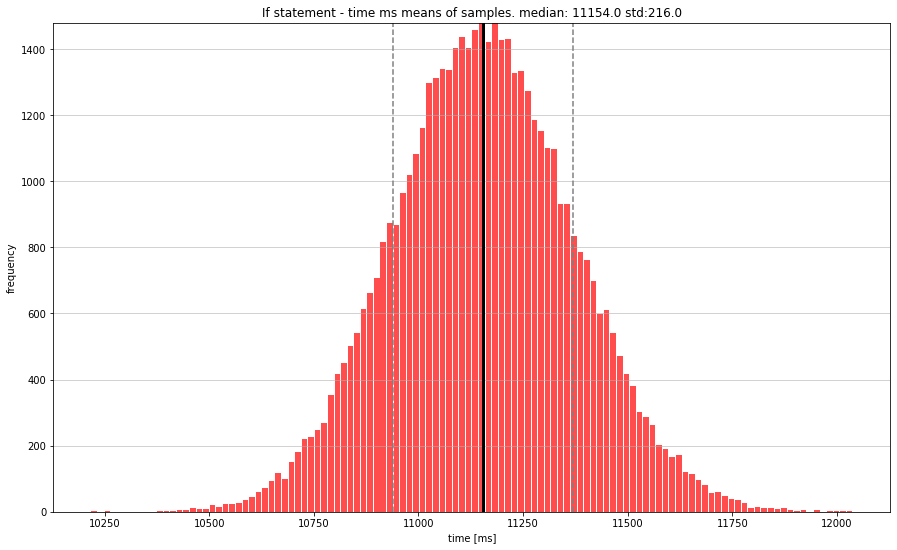

Ternary operator - time ms keeping 395 inliers


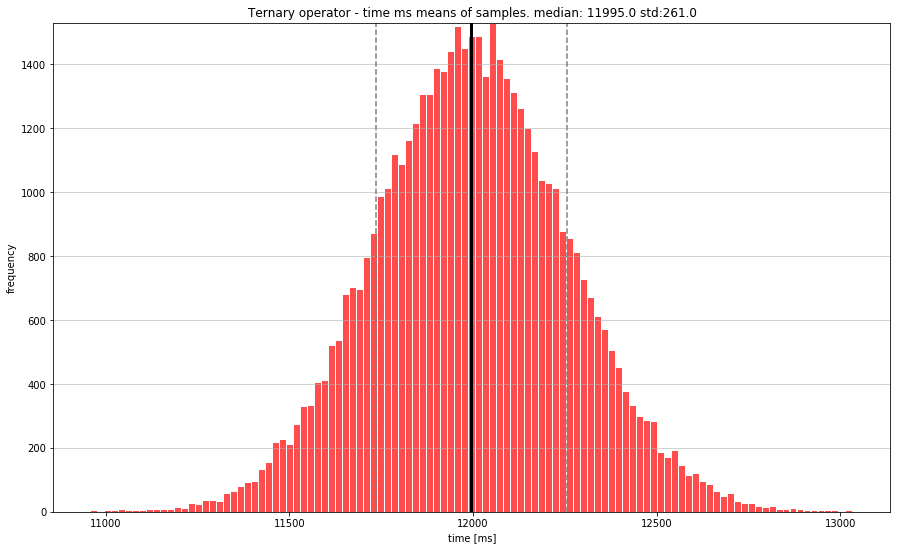

reading file data/order-of-if.csv
case a has 281 observations and case b has 271 observations
Positive first - time ms keeping 267 inliers


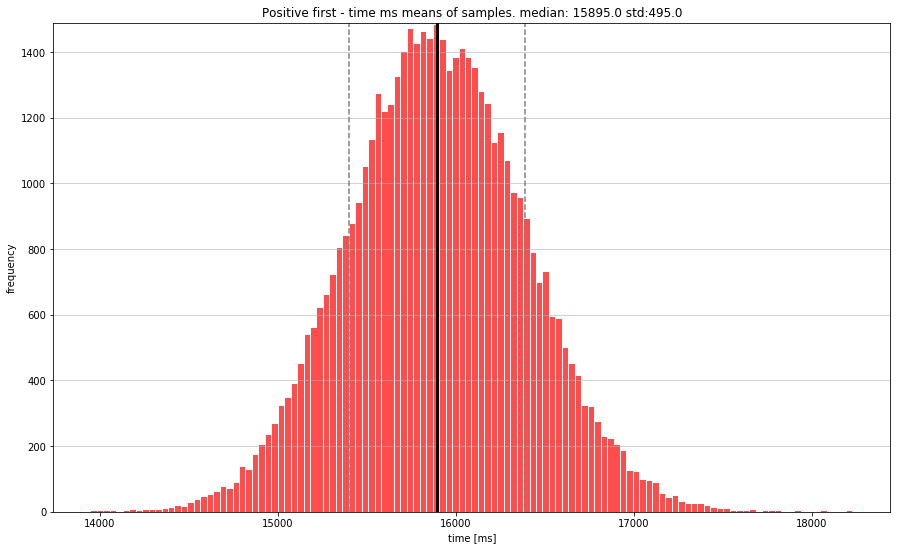

Negative first - time ms keeping 262 inliers


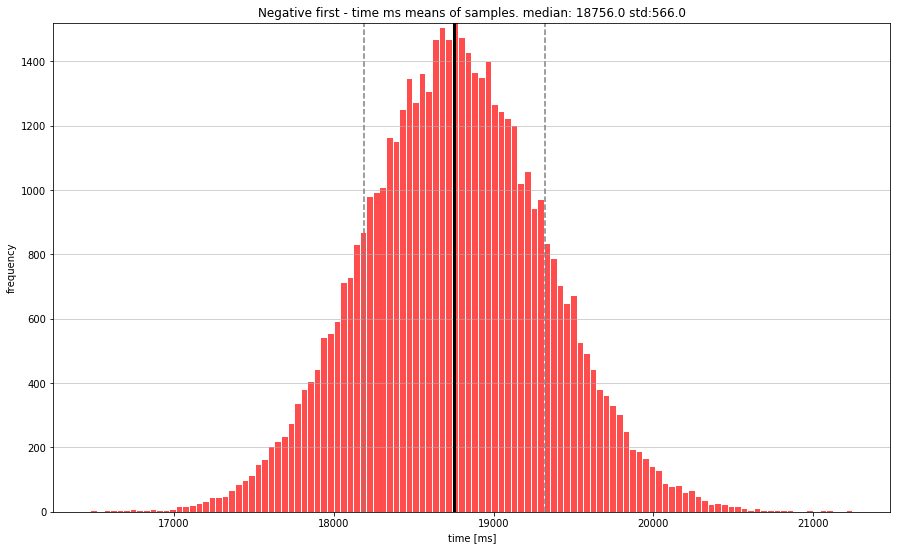

reading file data/chaining-intermediate.csv
case a has 230 observations and case b has 242 observations
Chaining methods - time (ms) keeping 210 inliers


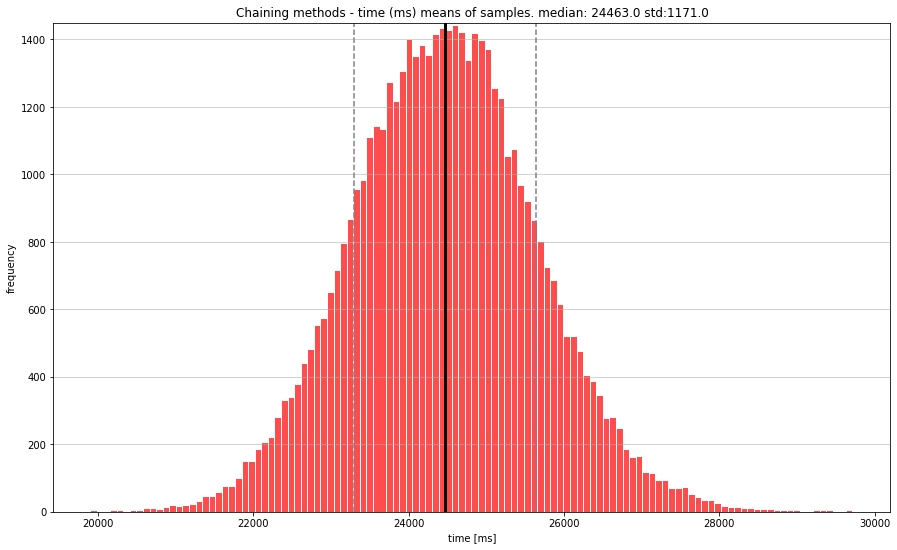

Intermediate variables - time (ms) keeping 234 inliers


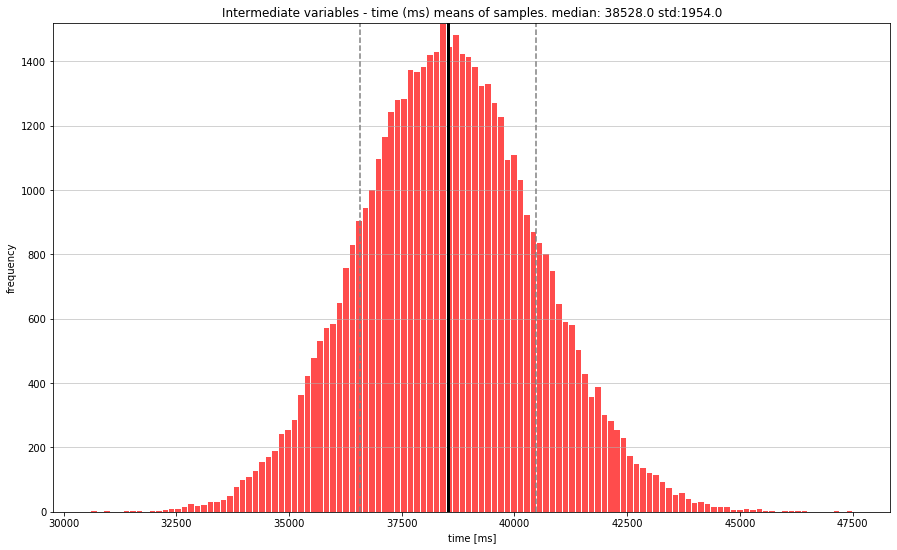

In [131]:
for filename in list_data_files:
    """
    read in each data file. 
    each data file is assumed to be a csv containing 
     - a header with the case name
     - two columns (and only two columns!)
    note that the number of rows differs between the columns, 
    pandas will fill the missing rows in with nulls.
    """
    filepath = os.path.join('data', filename)
    print('reading file', filepath)
    measured_times = pd.read_csv(filepath)
    casenames = measured_times.columns
    measured_times.columns = ['case_a', 'case_b'] # more convenient column names
    
    case_a = drop_nulls(measured_times['case_a'])
    case_b = drop_nulls(measured_times['case_b'])
    print('case a has', len(case_a), 'observations and case b has', len(case_b), 'observations')

    case_dict = dict(zip(casenames, [case_a, case_b]))
    # collect medians, variances, standard deviation for both cases here:
    case_meds = {}; case_vars = {}; case_stds = {}
    for casename in case_dict:
        """ 
        each case is treated in turn.
        - remove outliers (get inliers)
        - count inliers
        - draw num_samples samples, each of size num_inliers        
        """
        case = case_dict[casename]
#         case_histogram(case, casename, 'unfiltered')
        limits = get_inlier_limits(case)
        limits = (max(0, limits[0]), limits[1]) # handle negative lower range
        inlier_idx = case.apply(check_whether_inlier, args=limits)
        num_inliers = sum(inlier_idx)
        case = case[inlier_idx]
        print(casename, 'keeping', len(case), 'inliers')
#         case_histogram(case, casename, 'filtered')
        sum_of_means = 0
        list_of_sample_means = []
        for i in range(num_samples):
            """
            sample set of times, with replacement. 
            get same size sample of times as actual set.
            collect the mean of times from each sample.
            """
            sample = case.sample(num_inliers, replace=True)
            list_of_sample_means.append(sample.mean())
        
        case_meds[casename] = np.median(list_of_sample_means)
        case_vars[casename] = np.var(list_of_sample_means)
        case_stds[casename] = np.std(list_of_sample_means)
        # draw histogram of sample means
        histogram_of_means(list_of_sample_means, casename)  